## Logistic Regression for Rating Prediction

In [1]:
!pip install wordcloud

You should consider upgrading via the 'c:\users\xinyi\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import re

from tqdm import tqdm
from matplotlib import pyplot as plt
from urllib.request import urlopen
from numpy.linalg import norm
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,auc
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud
from fractions import Fraction

# default plot configurations 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150
sns.set()

### Loading Data
Load both the review data and the meta data.

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
        if i % 500000 == 0: print(i)
    return pd.DataFrame.from_dict(df, orient='index')

In [4]:
print("Start loading review data")
review_data = getDF('../data/Toys_and_Games.json.gz')
print("Finish loading review data")

# total length of list, this number equals total number of products
print(len(review_data))

Start loading review data
500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
4500000
5000000
5500000
6000000
6500000
7000000
7500000
8000000
Finish loading review data
8201231


In [5]:
print("Start loading meta data")
meta_data = getDF('../data/meta_Toys_and_Games.json.gz')
print("Finish loading meta data")
# total length of list, this number equals total number of products
print(len(meta_data))

Start loading meta data
500000
Finish loading meta data
633883


### Data Preprocessing

#### review data

Drop useless columns. 

In [6]:
review_data = review_data.drop(columns=['style'])

Technically, a user can only do one review at a review time for a product. Therefore, we remove the duplicates which share the same reviewerID, product asin, and unixReviewTime.

In [7]:
review_data.drop_duplicates(subset=['reviewerID', 'asin', 'unixReviewTime'], inplace=True)

Fill in 0, " " for NaN values in 'vote', 'reviewText', and 'summary'. Drop the remaining NaN values.

In [8]:
review_data['vote'] = review_data['vote'].str.replace(',', '').fillna(0).astype('int')

In [9]:
review_data['reviewText'] = review_data['reviewText'].fillna('')
review_data['summary'] = review_data['summary'].fillna('')

Change 'image' attribute into 0 1 column where 0 means no image provided, 1 means images provided

In [10]:
review_data['image'] = review_data['image'].isnull().astype('int')

In [11]:
review_data['image'] = 1 - review_data['image']

In [12]:
review_data = review_data.dropna()

In [13]:
print(len(review_data))

8002086


Convert "reviewTime" from string to datetime object. Extract year.

In [14]:
review_data = review_data[review_data.reviewTime.str.match(r"\d{2} \d{1,2}, \d{4}")]
review_data['reviewTime'] = pd.to_datetime(review_data['reviewTime'],format='%m %d, %Y', errors='coerce')
review_data['reviewYear'] = pd.DatetimeIndex(review_data['reviewTime']).year

Count the word-level length of "reviewText".

In [15]:
review_data['review_length'] = review_data['reviewText'].str.count(" ")+1

Convert numpy boolean to int (0 and 1) for the "verified" column.

In [16]:
review_data['verified'] = review_data['verified'].astype('int')

In [17]:
review_data.head(5)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,image,reviewYear,review_length
0,2.0,12,0,2016-09-22,A1IDMI31WEANAF,0020232233,Mackenzie Kent,"When it comes to a DM's screen, the space on t...",The fact that 50% of this space is wasted on a...,1474502400,0,2016,80
1,1.0,21,0,2016-09-18,A4BCEVVZ4Y3V3,0020232233,Jonathan Christian,An Open Letter to GaleForce9*:\n\nYour unpaint...,Another worthless Dungeon Master's screen from...,1474156800,0,2016,125
2,3.0,19,1,2016-09-12,A2EZ9PY1IHHBX0,0020232233,unpreparedtodie,"Nice art, nice printing. Why two panels are f...","pretty, but also pretty useless",1473638400,0,2016,257
3,5.0,0,1,2017-03-02,A139PXTTC2LGHZ,0020232233,Ashley,Amazing buy! Bought it as a gift for our new d...,Five Stars,1488412800,0,2017,14
4,1.0,3,1,2017-02-08,A3IB33V29XIL8O,0020232233,Oghma_EM,As my review of GF9's previous screens these w...,Money trap,1486512000,0,2017,25


#### metadata

Extract useful columns and filter out 'price' and 'imageURL' with the desired format.

In [18]:
meta_data = meta_data[['price', 'imageURL','asin']]

In [19]:
meta_data = meta_data[meta_data['price'].str.match(r'\$[0-9]*.[0-9]*')]
meta_data['price'] = meta_data['price'].str.extract(r'\$(.*)')
meta_data['price'] = pd.to_numeric(meta_data['price'],errors='coerce')

In [20]:
meta_data['imageURL'] = meta_data['imageURL'].str.len()

In [21]:
meta_data = meta_data.dropna()
print(len(meta_data))

314276


In [22]:
meta_data.head(5)

,price,imageURL,asin
3,24.95,0,0004983289
4,4.92,0,0006466222
5,13.50,1,0020232233
9,35.09,2,019848710X
10,28.81,0,0198487126


#### Merge data

Merge review data and purchase(meta_data) together based on the products' asin(ID). Then extract useful attributes for the predicting of overall rank from this merged data frame. We use the previous EDA's result for this selection process.

In [23]:
all_data = pd.merge(review_data, meta_data, on="asin")

In [24]:
all_data = all_data[['review_length', 'reviewYear', 'reviewText', 'image', 'imageURL','overall']]

In [25]:
len(all_data)

5628873

In [26]:
all_data

,review_length,reviewYear,reviewText,image,imageURL,overall
0,80,2016,"When it comes to a DM's screen, the space on t...",0,1,2.0
1,125,2016,An Open Letter to GaleForce9*:\n\nYour unpaint...,0,1,1.0
2,257,2016,"Nice art, nice printing. Why two panels are f...",0,1,3.0
3,14,2017,Amazing buy! Bought it as a gift for our new d...,0,1,5.0
4,25,2017,As my review of GF9's previous screens these w...,0,1,1.0
...,...,...,...,...,...,...
5628868,43,2017,This is a very cute Easter version of the belo...,0,2,5.0
5628869,7,2017,Grandson loved it.\nGrandma didn't like the pr...,0,2,5.0
5628870,14,2017,You are still my friend who has been my best s...,0,2,4.0
5628871,1,2018,Love,0,2,5.0


### Sentiment Analysis (Logistic Regression)
We want to investigate if logistic regression can make good predictions for ratings based on the review text. 
1. We use logistic regression because the overall rank attribute is a categorical attribute. We also assume the logit has a linear relationship with all the attributes. 
2. We use the GridSearchCV method of sci-kit learn to find the best hyperparameter for our model. Cross validation is also used here. We choose cv=5, scoring="accuracy" and tested the inverse of regularization strength being 0.001 to 1000 and penalty being l1, l2 or both. The result tells us the model is most accurate when the inverse of regularization strength is ten, and the penalty is l2.
3. With the method TfidfVectorizer of sci-kit learn, we transfer the review text into a matrix of the counts of different words in each review text. We also use the get_dummies making the categorical attribute 'reviewYear' being 20 indicator variables. The Combination of the matrix, 20 indicator variables table and the table of 'review_length,' 'image'(whether the review includes images or not), 'imageURL'(whether the product includes images or not)is the X for our current model.
4. The logistic regression model we build is multi-class. It includes five categories which is also the original rating scale. This is the Y for our current model.
5. We split our data into training and test sets at a ratio of 3:1. The lengths of training and test sets are 4221654 and 1407219, respectively.
6. The loss function of our model is cross-entropy loss.

In [27]:
# setting the X and y for our model
df = all_data.copy()
X = df[['review_length', 'reviewYear', 'reviewText', 'image', 'imageURL']]
y = df['overall']

In [28]:
def text_fit(X, y, model, clf_model, coef_show=1, plot_show=1):
    # preprocess X and split to trianing and test set.
    X_c_1 = model.fit_transform(X['reviewText'])
    X_c_1 = X_c_1.A
    X_c_2 = X[['review_length', 'image', 'imageURL']].to_numpy()
    X_c_3 = pd.get_dummies(X['reviewYear'], columns=['name']).to_numpy()
    X_c = np.concatenate((X_c_1, X_c_2), axis=1)
    X_c = np.concatenate((X_c, X_c_3), axis=1)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=42)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    
    #train the model and get model result
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    # find word used mostly in the model
    if coef_show == 1: 
        w = np.array(list(model.get_feature_names()) + ['review_length', 'image', 'imageURL'] + [1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
        coef = clf.coef_.tolist()[0]
        coef_df = pd.DataFrame({'Attributes' : w, 'Coefficient' : coef}).sort_values(['Coefficient', 'Attributes'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coef_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coef_df.tail(20).to_string(index=False))
    


#### Use only CountVectorizer
While the DummyClassifier model has an accuracy of $48\%$, the accuracy of logistic regression improves a lot and reaches $66.8\%$. However, if we look at the top 20 positive attributes and 20 negative attributes, we observe some meaningless tokens such as "love" and "loves" staying together. We wonder if we can improve this by using TfIdf.

In [29]:
c = CountVectorizer(max_features = 40,stop_words = 'english')

In [30]:
text_fit(X, y, c, DummyClassifier(),0,0)

# features: 63
# train records: 4221654
# test records: 1407219


c:\users\xinyi\appdata\local\programs\python\python37\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Model Accuracy: 0.48020954805186683


In [31]:
text_fit(X, y, c, LogisticRegression())

# features: 63
# train records: 4221654
# test records: 1407219


c:\users\xinyi\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Accuracy: 0.6677425475352451

-Top 20 positive-
    Attributes  Coefficient
       product     0.198233
           don     0.166428
           buy     0.160765
           box     0.123145
         image     0.079899
          2017     0.071876
           got     0.061861
        pieces     0.044213
         small     0.039188
          2018     0.034577
     christmas     0.030694
        bought     0.027979
       quality     0.017756
          time     0.016300
      imageURL     0.012334
           use     0.008577
           toy     0.004602
 review_length     0.002940
          2004     0.000329
          2005     0.000282

-Top 20 negative-
Attributes  Coefficient
      2013    -0.097053
       set    -0.100304
      play    -0.108527
    really    -0.109418
      year    -0.110543
      2014    -0.125357
      kids    -0.126585
      game    -0.134511
      easy    -0.145323
       old    -0.153251
      cute    -0.180349
      nice    -0.194766
   perfect    -0.199965
   

#### Use TfidfVectorizer
By using TfidfVectorizer, we can see that most word are meaningful and indicate a polarity of sentiment. The accuracy of logistic regression also increase a bit to $66.9\%$.

In [32]:
tfidf = TfidfVectorizer(max_features = 40,stop_words = 'english')

In [33]:
text_fit(X, y, tfidf, LogisticRegression())

# features: 63
# train records: 4221654
# test records: 1407219


c:\users\xinyi\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model Accuracy: 0.6690067430868969

-Top 20 positive-
Attributes  Coefficient
       don     0.219690
   product     0.199388
       buy     0.190710
      2017     0.170903
       box     0.166349
     image     0.148605
     small     0.108644
       got     0.096622
      2018     0.083849
    pieces     0.080685
       use     0.063797
      like     0.054747
      time     0.049840
   quality     0.046071
    bought     0.040756
  imageURL     0.030295
      just     0.022969
 christmas     0.019479
      2016     0.017358
      make     0.009063

-Top 20 negative-
Attributes  Coefficient
      2015    -0.077106
      play    -0.078799
  daughter    -0.081603
      year    -0.107895
      kids    -0.113794
      easy    -0.123798
      game    -0.126288
       old    -0.133292
      2013    -0.163939
    little    -0.172947
      2014    -0.177407
      nice    -0.187406
      cute    -0.191241
   perfect    -0.218120
      good    -0.221375
     loved    -0.242545
       fun    -

#### Find better hyperparameter
We use the default setting of logistic regression in the previous part. Now, we want to find the best hyperparameter setting with the help of the GridSearchCV method of sci-kit learn. We tested the inverse of regularization strength being 0.001 to 1000 and penalty being l1, l2 or both.

In [34]:
tfidf = TfidfVectorizer(max_features = 40,stop_words = 'english')

In [35]:
X_c_1 = tfidf.fit_transform(X['reviewText'])
X_c_1 = X_c_1.A
X_c_2 = X[['review_length', 'image', 'imageURL']].to_numpy()
X_c_3 = pd.get_dummies(X['reviewYear'], columns=['name']).to_numpy()
X_c = np.concatenate((X_c_1, X_c_2), axis=1)
X_c = np.concatenate((X_c, X_c_3), axis=1)
print('# features: {}'.format(X_c.shape[1]))
X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=42)
print('# train records: {}'.format(X_train.shape[0]))
print('# test records: {}'.format(X_test.shape[0]))


# features: 63
# train records: 4221654
# test records: 1407219


In [36]:
clf_model = LogisticRegression()
param_grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2", "elasticnet"]}# l1 lasso l2 ridge or both
# defining parameter range
grid = GridSearchCV(clf_model, param_grid, cv=5, scoring='accuracy', return_train_score=False, verbose=1)

In [37]:
#train the model and get model result
grid_search = grid.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\users\xinyi\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\xinyi\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\xinyi\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\users\xinyi\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' 

c:\users\xinyi\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\xinyi\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\xinyi\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\users\xinyi\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
c:\users\xinyi\appdata\lo

c:\users\xinyi\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\xinyi\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

c:\users\xinyi\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\xinyi\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

In [38]:
print("tuned hpyerparameters :(best parameters) ",grid_search.best_params_)
print("accuracy :",grid_search.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.6690091134381713


The result tells us the model is most accurate when the inverse of regularization strength is ten, and the penalty is l2. And we use this as our final model which gives an accuracy of $66.8\%$. This is a little bit smaller than the previous model with a default setting for logistic regression, which might be caused by overfitting.

In [39]:
clf_model = LogisticRegression(C = 10.0, penalty = 'l2')
#train the model and get model result
clf_model = clf_model.fit(X_train, y_train)

c:\users\xinyi\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [40]:
acc = clf_model.score(X_test, y_test)
print ('Model Accuracy: {}'.format(acc))

Model Accuracy: 0.6686691979002558


We also draw the ROC curve to find the performance of our model for different rating classes. From the ROC curves, we can find that the model performs well for rating being 1,2,3 and 5 but perform not that well for rating being 4(close to the diagonal）.

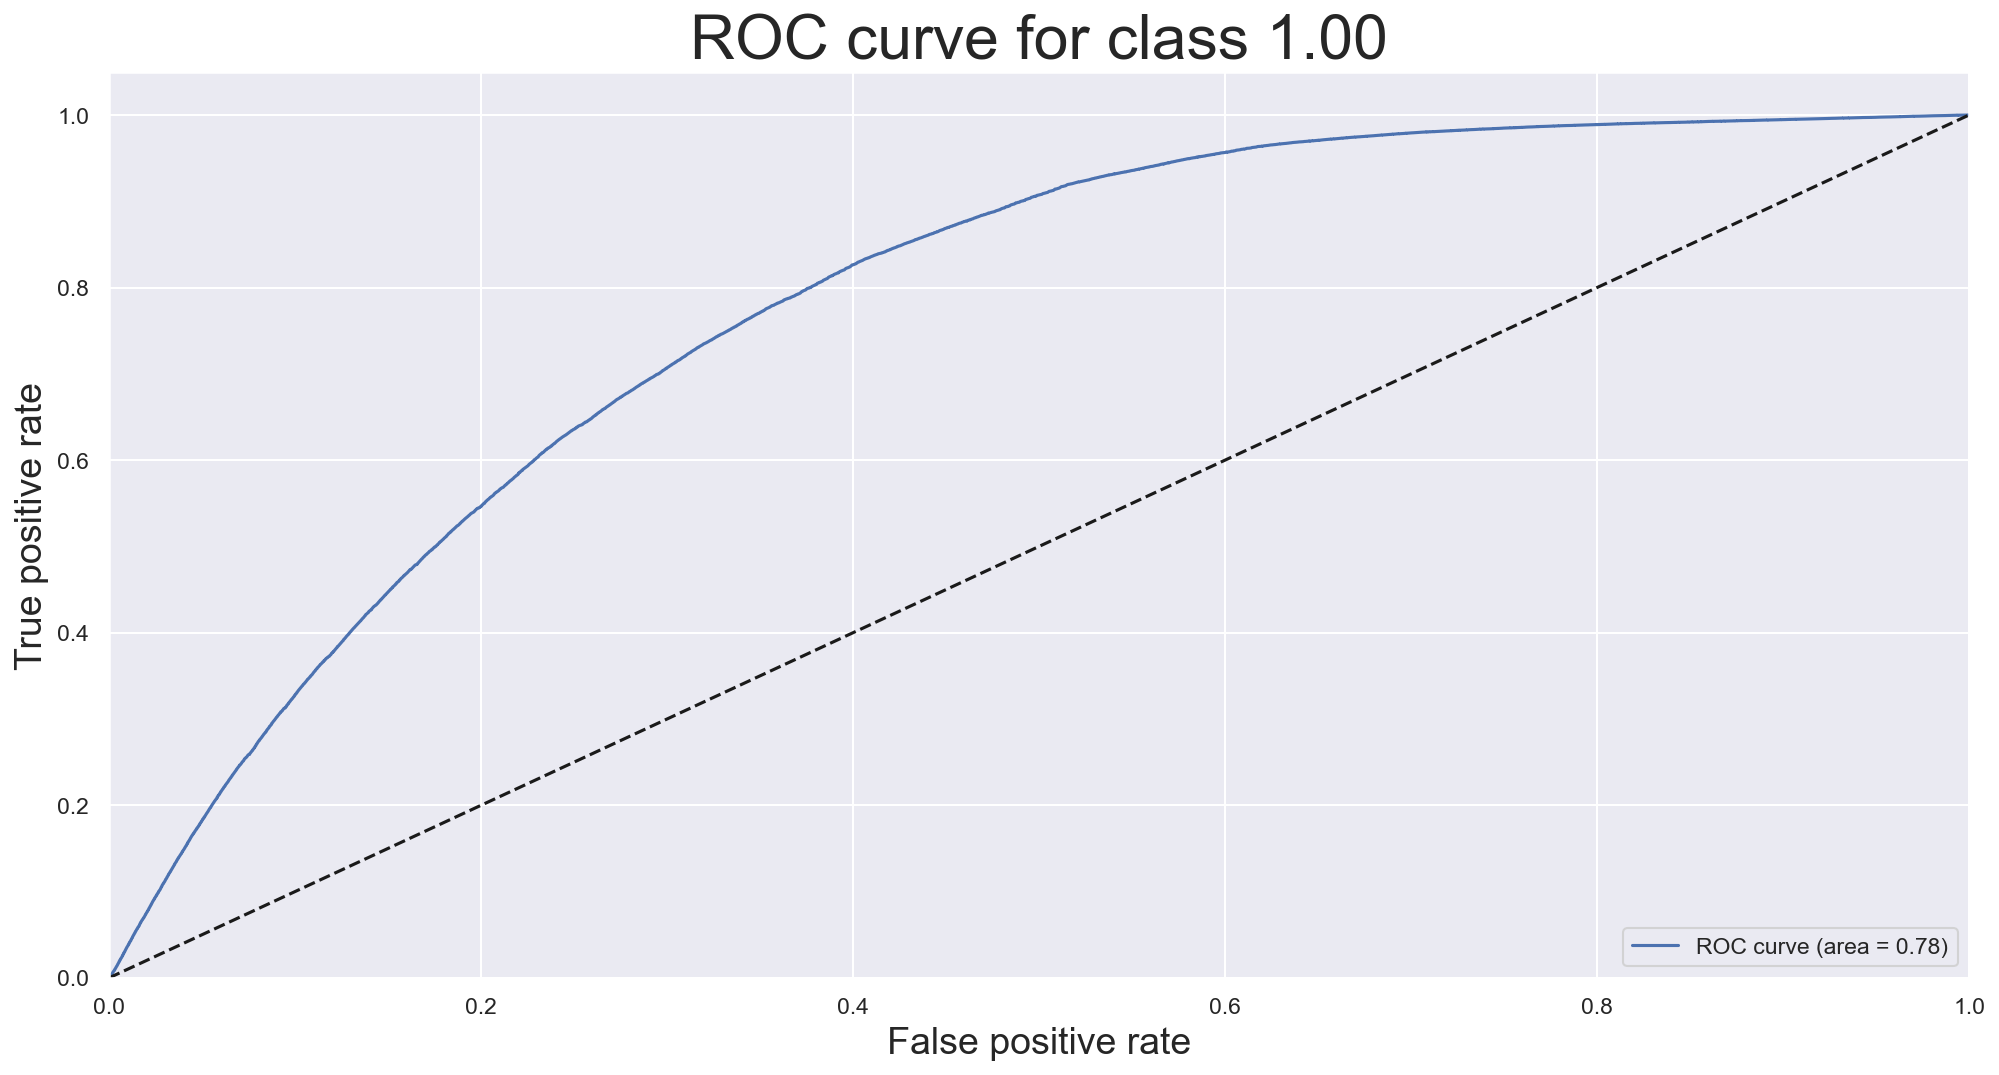

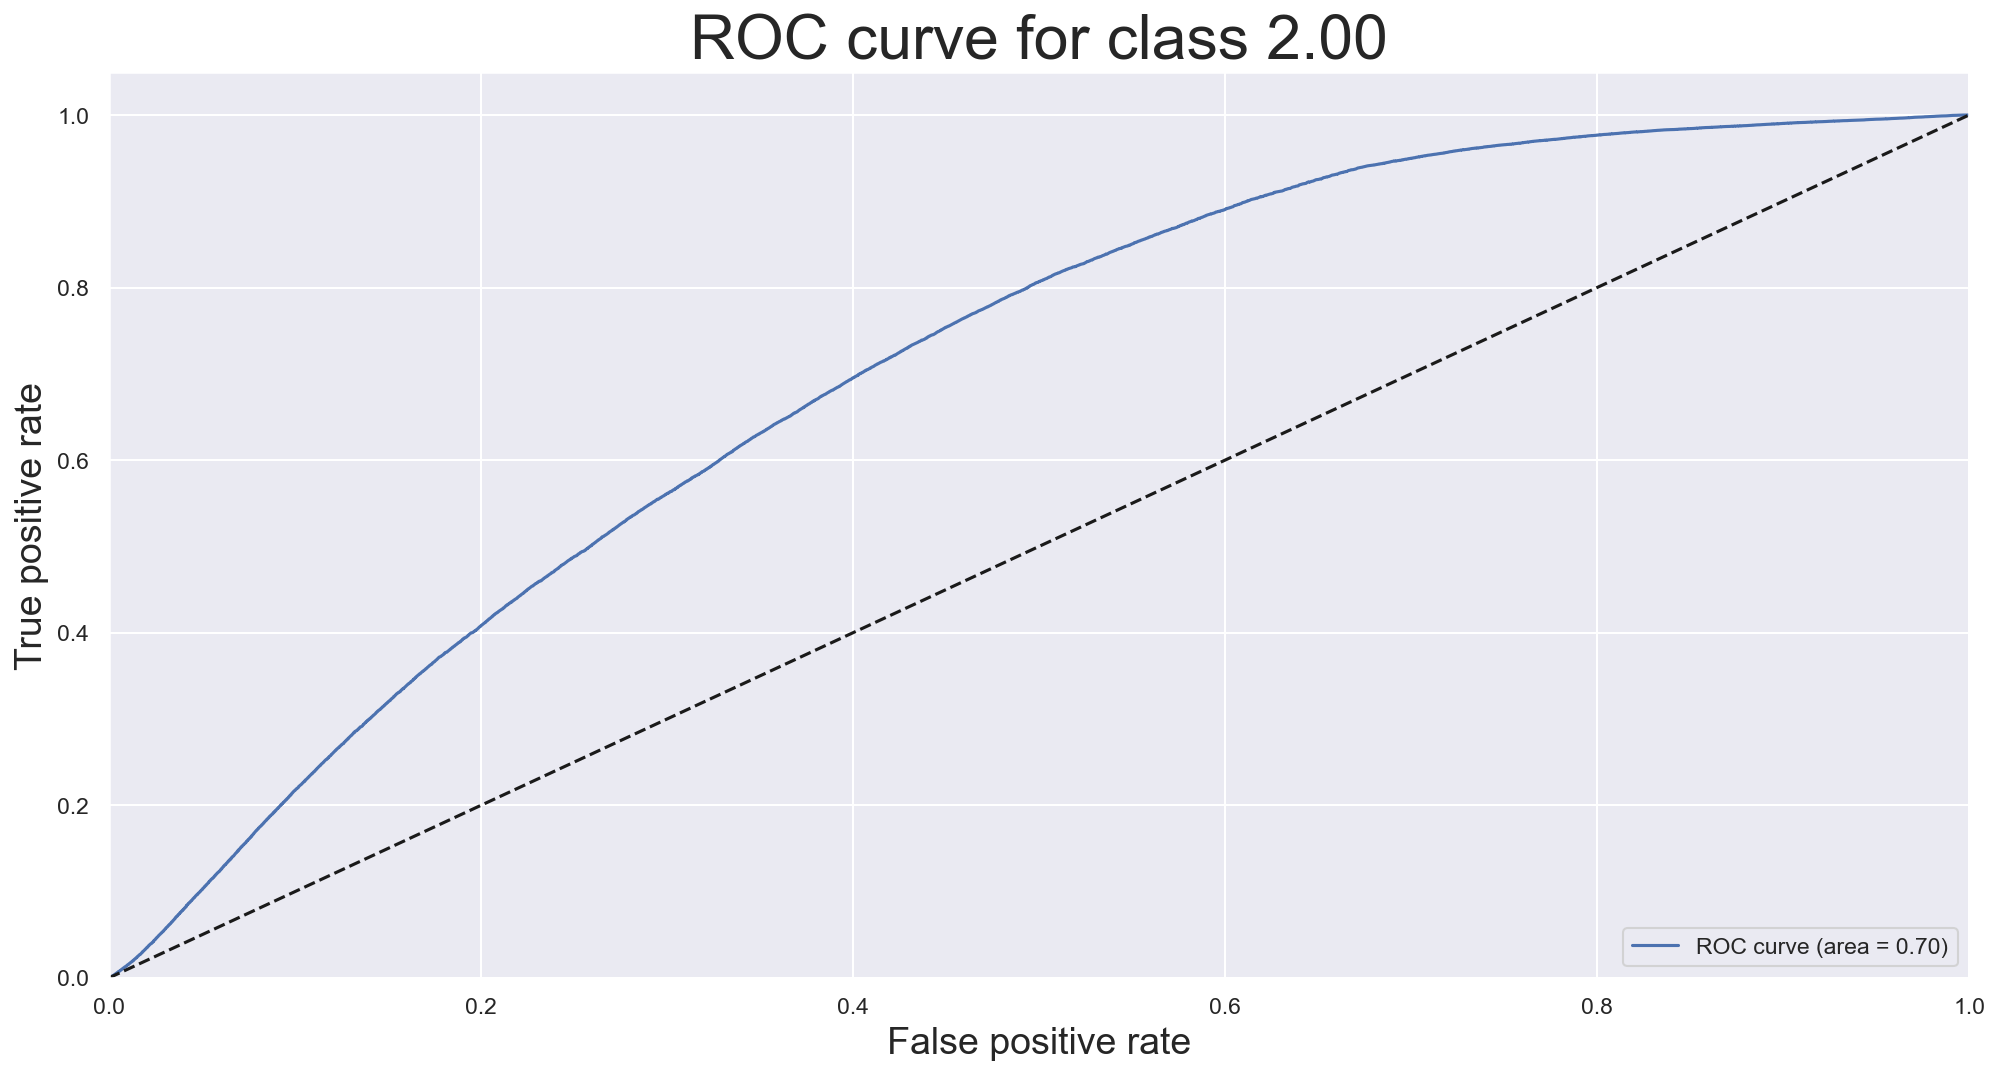

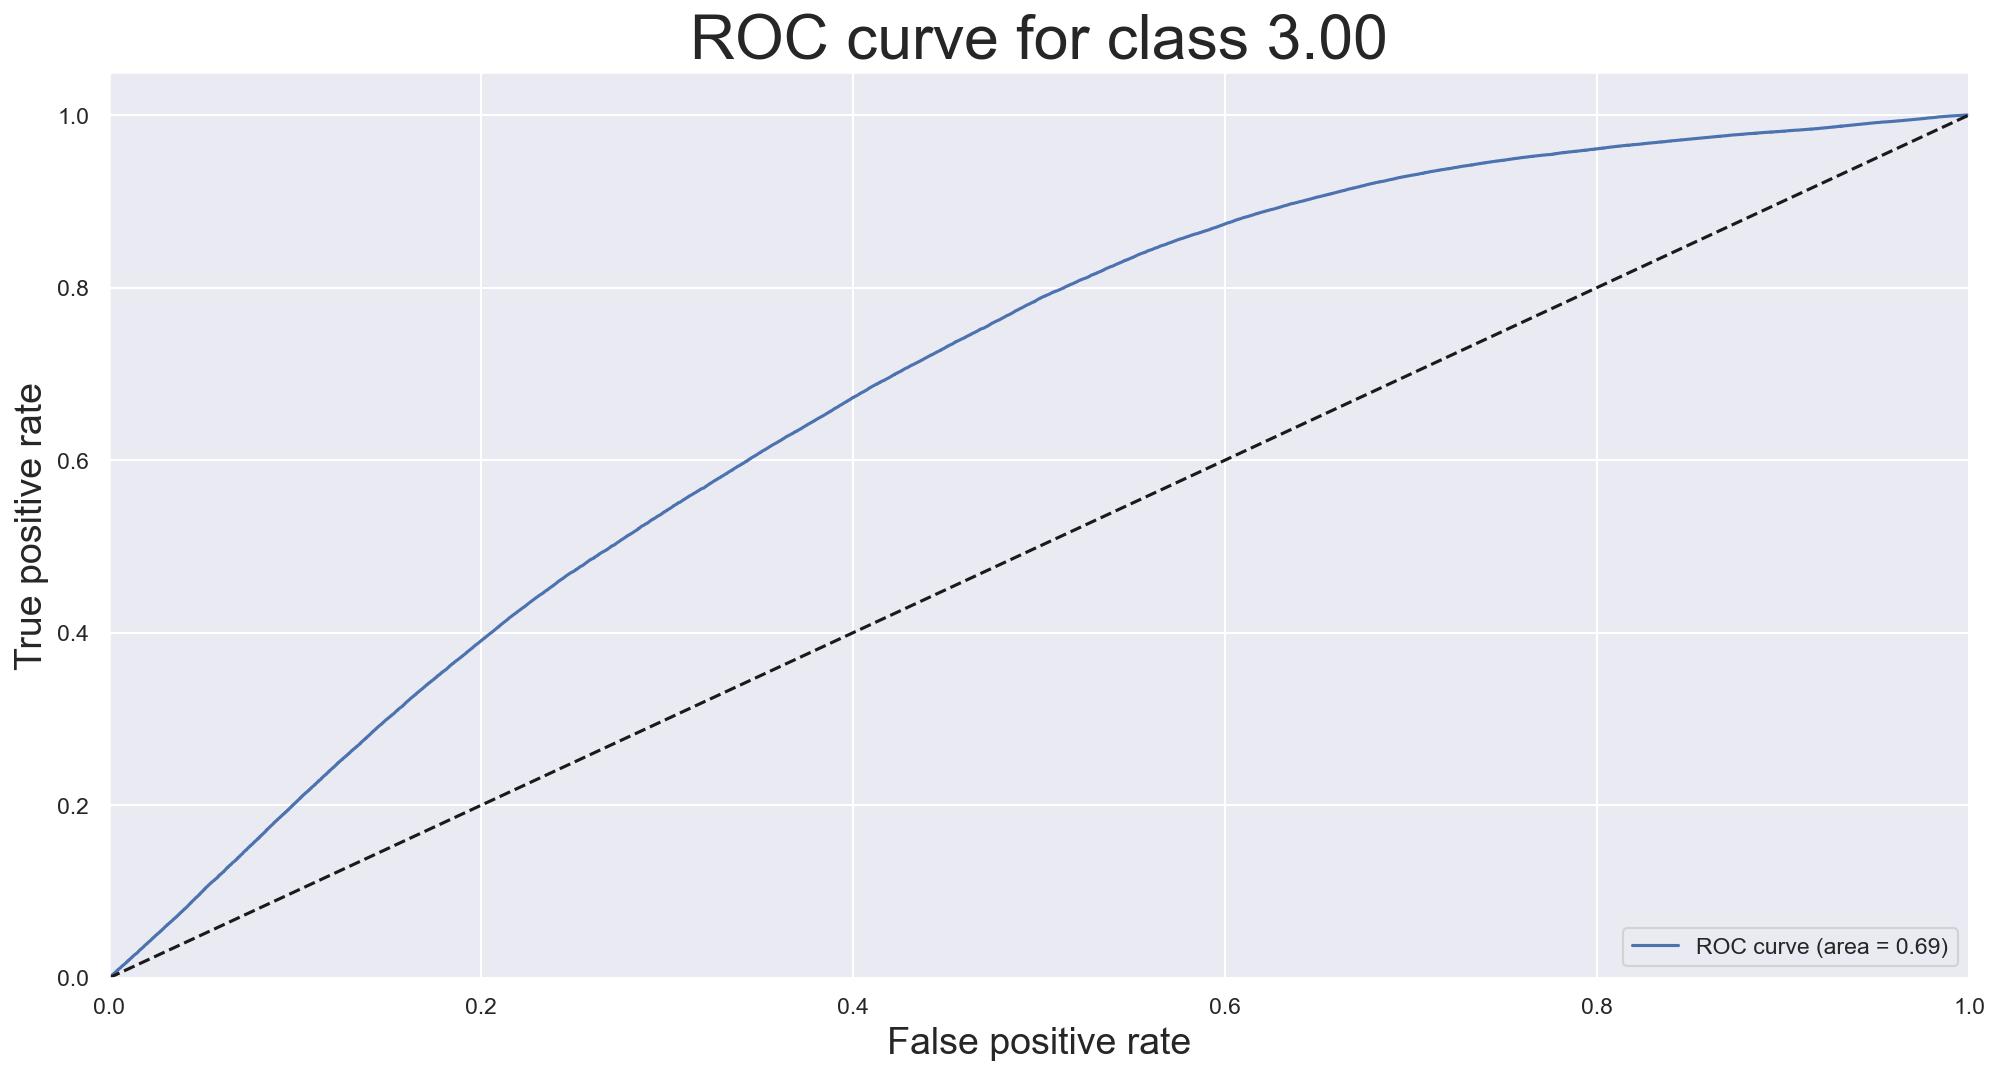

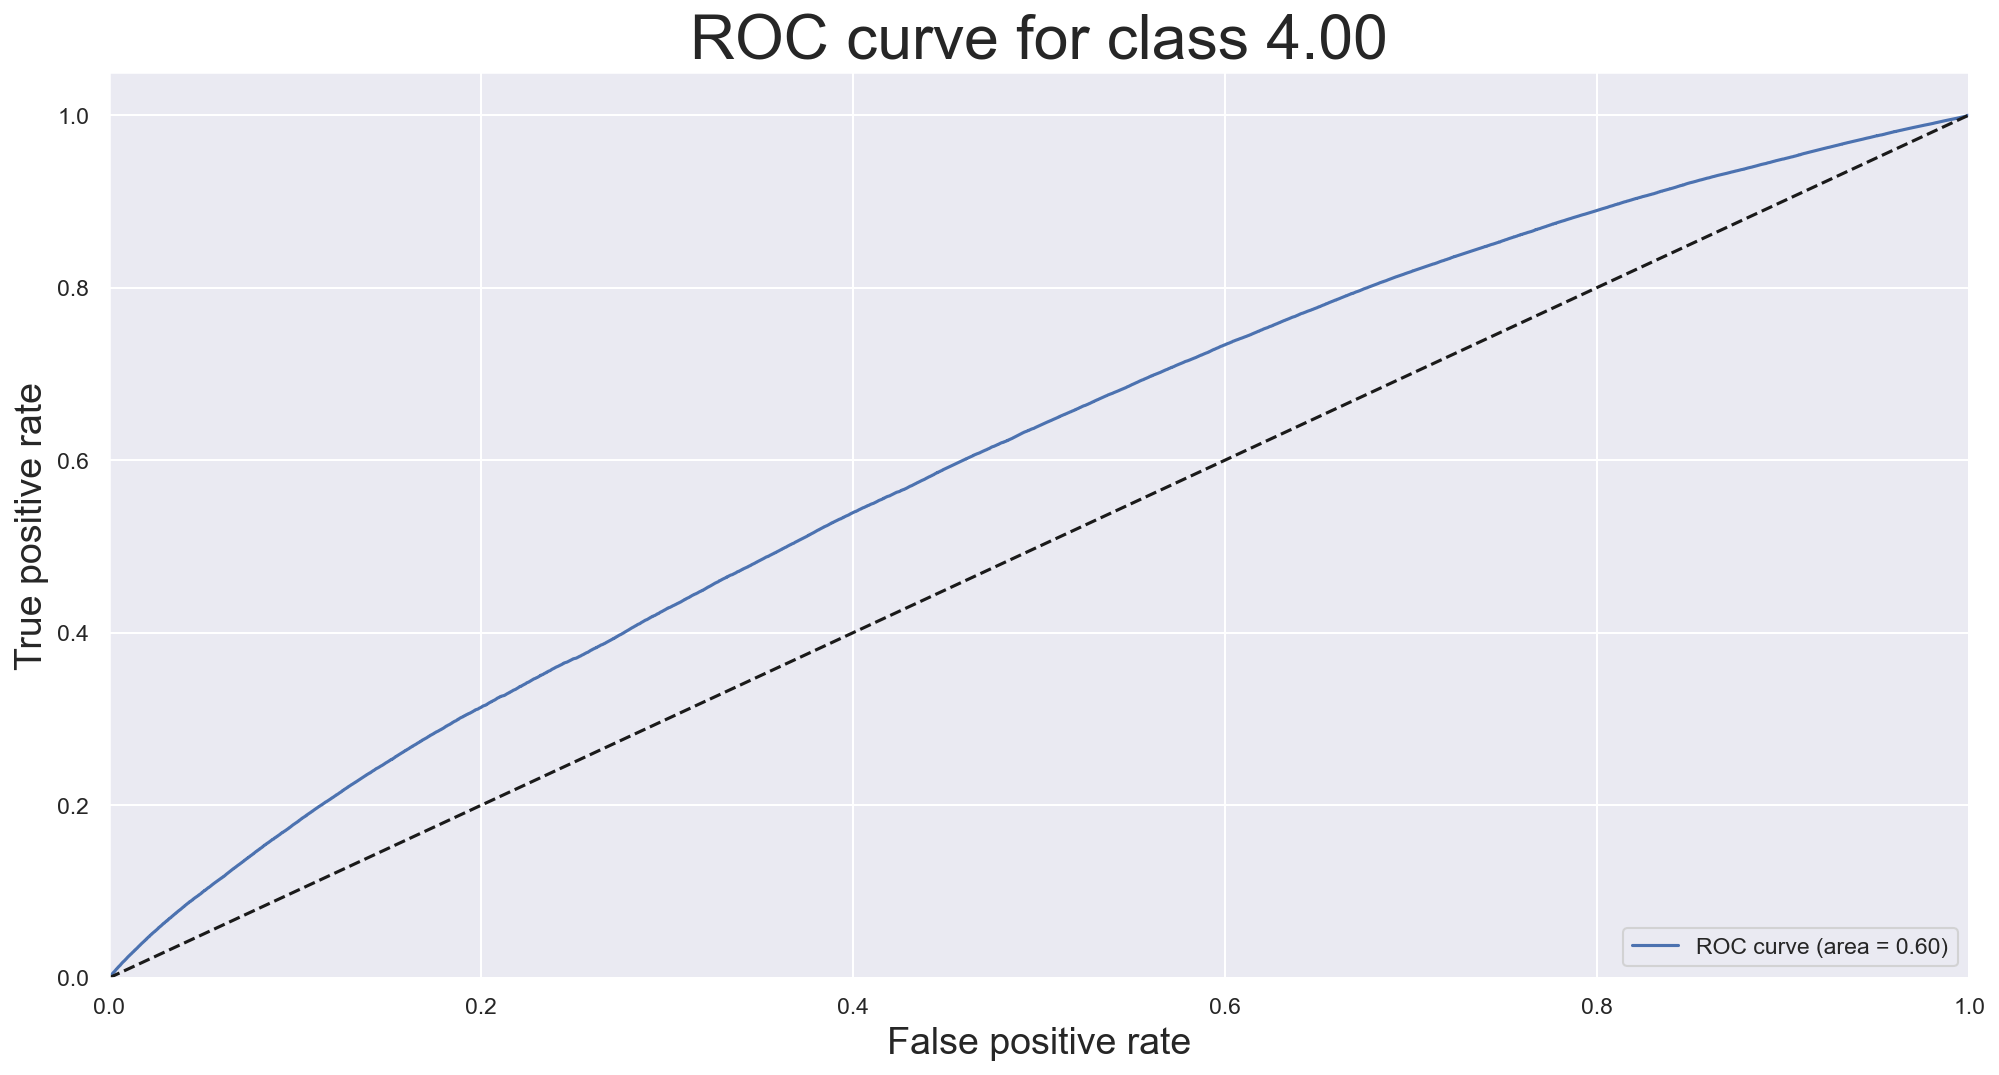

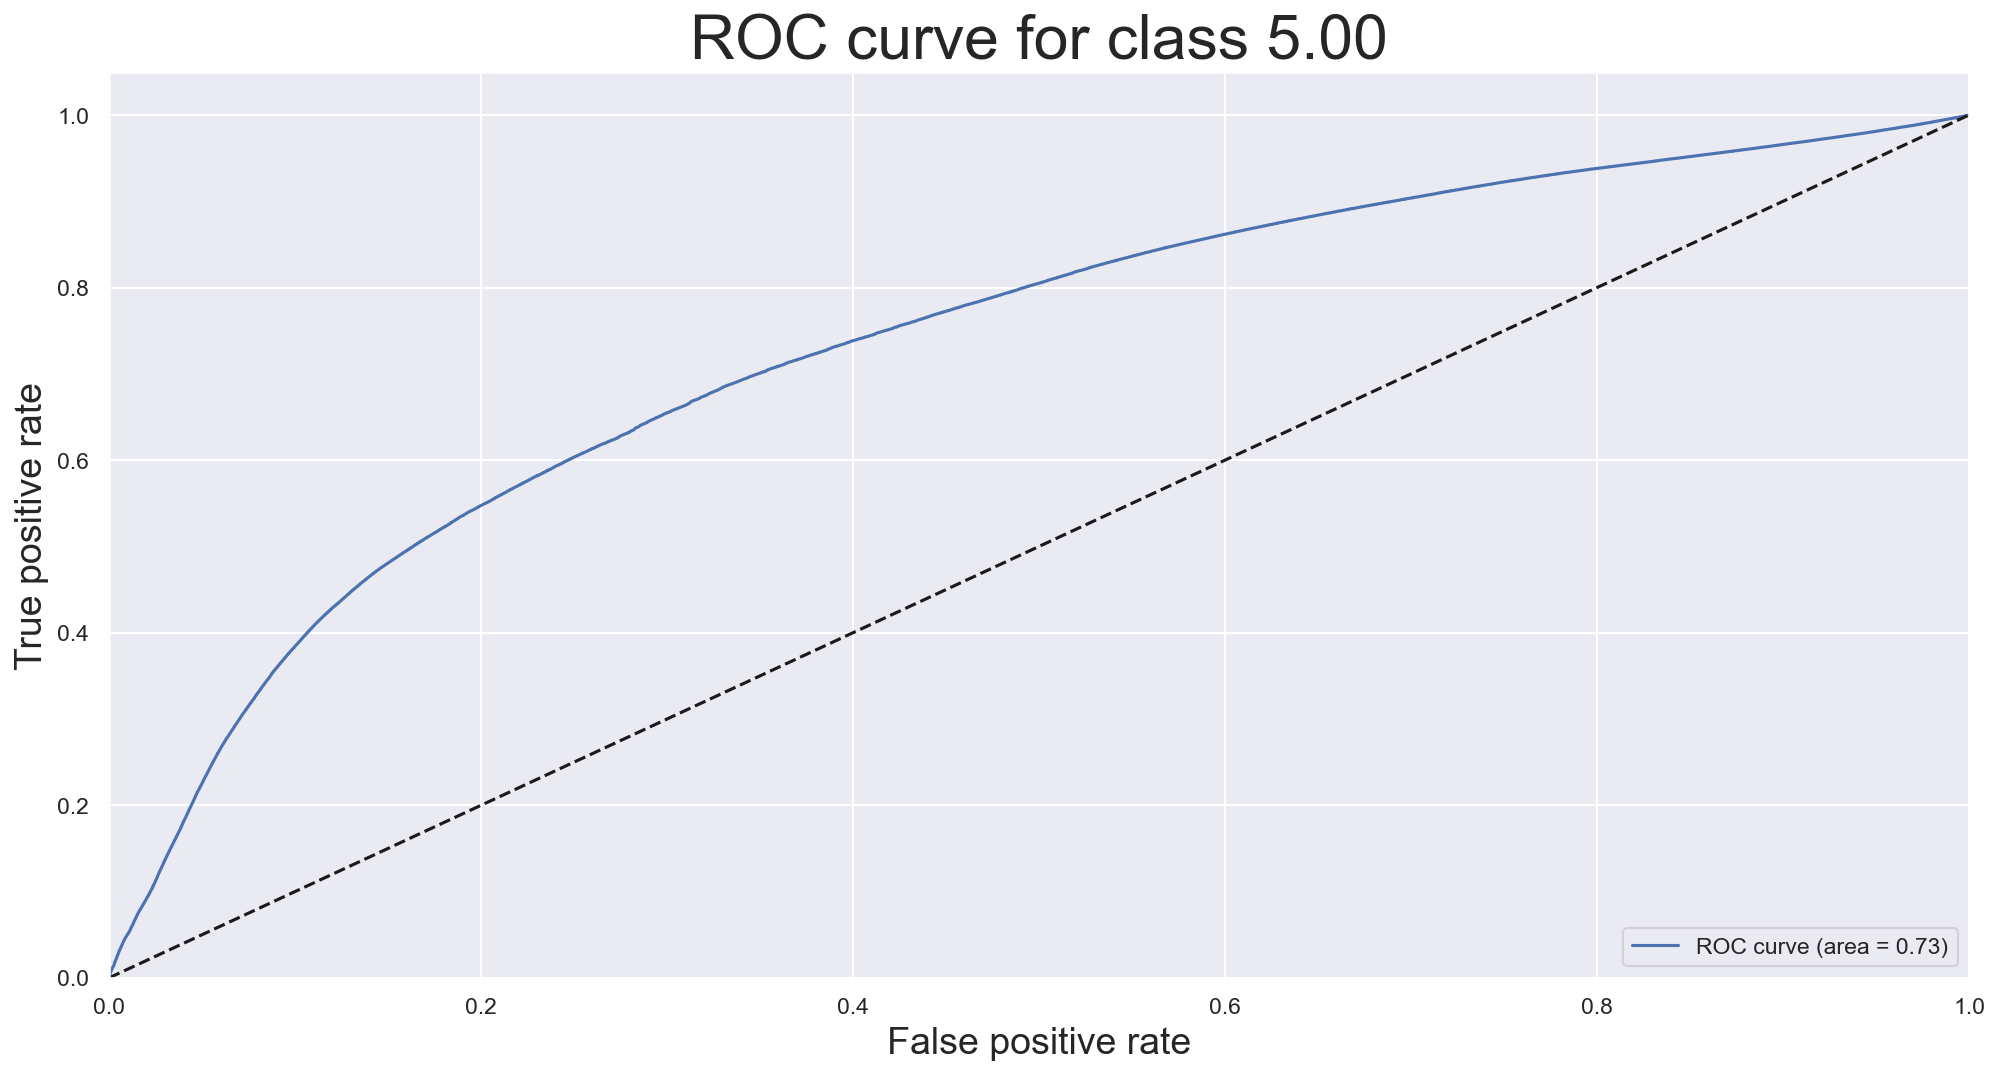

In [41]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in [1,2,3,4,5]:
    y_prob = clf_model.predict_proba(X_test)[:, i-1]
    fpr[i], tpr[i], _ = roc_curve(y_test, y_prob, pos_label = i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in [1,2,3,4,5]:
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False positive rate", fontsize=18)
    plt.ylabel("True positive rate", fontsize=18)
    plt.title("ROC curve for class %0.2f" % i, fontsize=30)
    plt.legend(loc="lower right")
    plt.show()

#### Future improvement
According to the result of ROC curves, maybe we can add more weight to the rows with the overall rating being 4 in the future improvement to have a higher accuracy.